라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = 'doRegressor_tank1scale'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('Day')
    plt.ylabel('DO')
    plt.title('day time')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [3]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 0.27494287  0.11629058  0.26080635 ... -0.15846932 -0.26851583
   0.04288037]
 [ 0.27981973 -0.08040359  0.04872732 ... -0.04500006 -0.20901754
   0.0122924 ]]


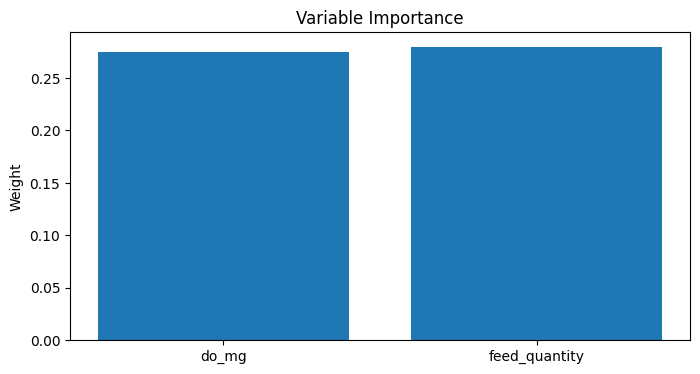

In [4]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(2), weights[:, 0])
ax.set_xticks(range(2))
ax.set_xticklabels(['do_mg', 'feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [5]:
#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_tank = japonica_validation[japonica_validation['tank_id']==tank]

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_validation_features = japonica_validation_tank[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_validation_features = japonica_validation_features.fillna(0)

# 시계열 데이터의 개수 확인
validation_counts = japonica_validation_features.groupby(japonica_validation_features['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_data = japonica_validation_features[~japonica_validation_features['mea_dt'].dt.date.isin(to_delete)]

# 날짜 데이터를 인덱스로 전환
japonica_validation_data.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_validation_data = japonica_validation_data.sort_index()

In [6]:
# 한달 동안의 데이터 추출
one_day_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 20:59']
oneday_X_test = one_day_data[['do_mg', 'feed_quantity']]
one_day_data = japonica_validation_data.loc['2021-07-21 03:00':'2021-09-08 23:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 2))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 359 nVar: 2
nCar: 64620 nVar: 1
nCar: 359 nVar: 180


12/12 [==============================] - 2s 63ms/step
64620


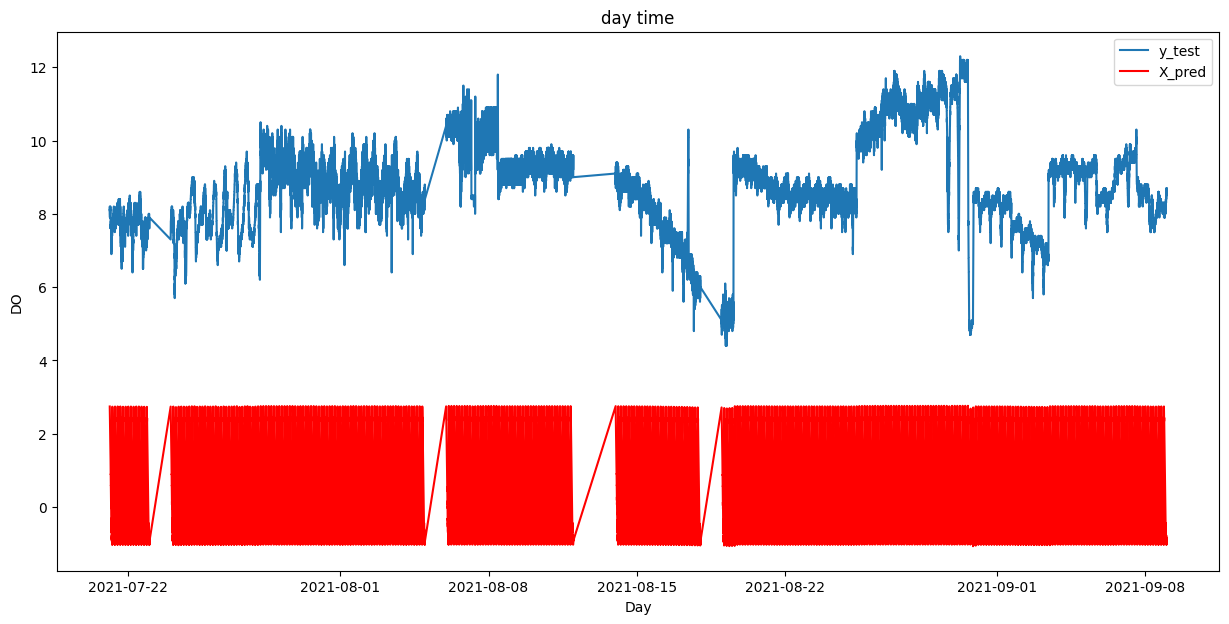

12/12 [==============================] - 2s 59ms/step - loss: 72.1495 - mae: 8.3205 - r_squared: -210.7400
MSE // MAE // R-squared  [72.14948272705078, 8.320541381835938, -210.739990234375]


In [7]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape)

In [8]:
# 한주 동안의 데이터 추출
one_day_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-31 20:59']
oneday_X_test = one_day_data[['do_mg', 'feed_quantity']]
one_day_data = japonica_validation_data.loc['2021-07-21 03:00':'2021-07-31 23:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 2))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 79 nVar: 2
nCar: 14220 nVar: 1
nCar: 79 nVar: 180


3/3 [==============================] - 0s 62ms/step
14220


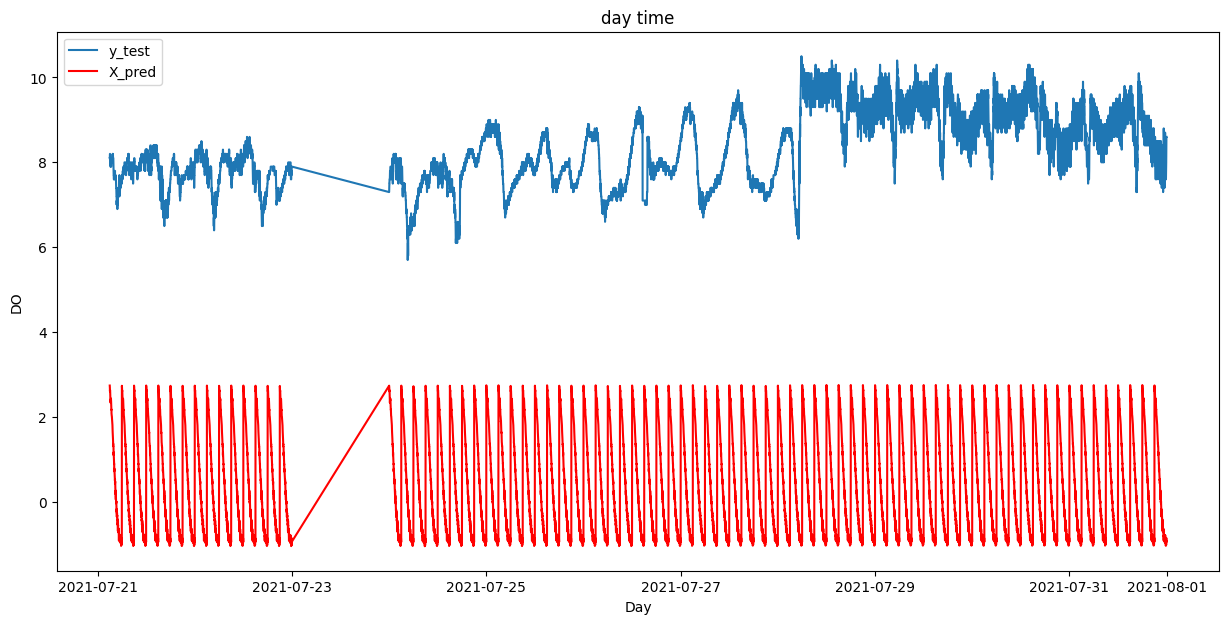

3/3 [==============================] - 0s 59ms/step - loss: 64.2695 - mae: 7.8794 - r_squared: -177.6055
MSE // MAE // R-squared  [64.26953125, 7.879419326782227, -177.60546875]


In [9]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape)

In [10]:
# 하루 동안의 데이터 추출
one_day_data = japonica_validation_data.loc['2021-07-29 00:00':'2021-07-29 20:59']
oneday_X_test = one_day_data[['do_mg', 'feed_quantity']]
one_day_data = japonica_validation_data.loc['2021-07-29 03:00':'2021-07-29 23:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 2))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 7 nVar: 2
nCar: 1260 nVar: 1
nCar: 7 nVar: 180


1/1 [==============================] - 0s 61ms/step
1260


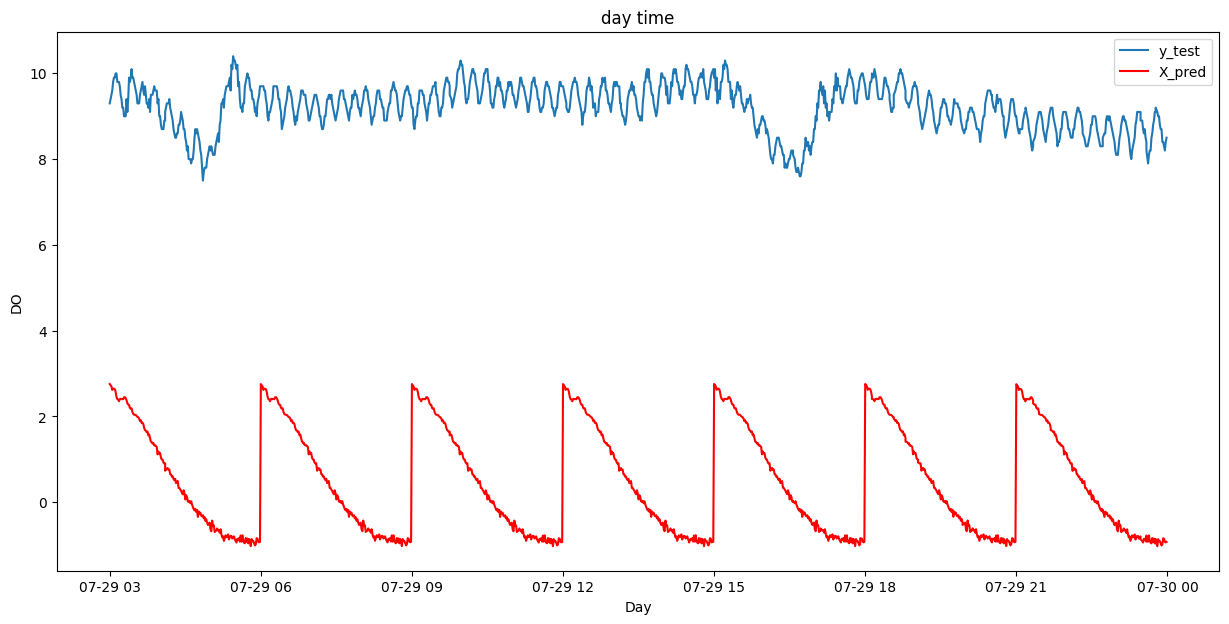

1/1 [==============================] - 0s 71ms/step - loss: 78.3579 - mae: 8.7579 - r_squared: -275.0346
MSE // MAE // R-squared  [78.35794830322266, 8.757940292358398, -275.0346374511719]


In [11]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape)

In [ ]:
# 한 동안의 데이터 추출
one_day_data = japonica_validation_data.loc['2021-08-22 00:00':'2021-08-22 11:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_validation_data.loc['2021-08-22 03:00':'2021-08-22 14:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 9
nCar: 720 nVar: 1
nCar: 4 nVar: 180


In [ ]:
import pandas as pd

pd.reset_option('display.max_rows')  # 기본값으로 초기화
pd.reset_option('display.max_columns')  # 기본값으로 초기화

In [ ]:
oneday_X_test

,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
mea_dt,,,,,,,,,
2021-08-22 00:00:00,8.9,28.9,4.88,250.4,32.7,0.0,3.9,0.0,0.0
2021-08-22 00:01:00,8.8,28.9,4.88,250.7,32.5,0.0,4.0,0.0,0.0
2021-08-22 00:02:00,8.5,28.9,4.88,250.7,32.5,0.0,4.0,0.0,0.0
2021-08-22 00:03:00,8.5,28.9,4.88,250.7,32.8,0.0,4.0,0.0,0.0
2021-08-22 00:04:00,8.6,28.9,4.89,250.5,32.8,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2021-08-22 11:55:00,8.7,28.8,4.85,246.1,33.0,0.0,3.9,0.0,0.0
2021-08-22 11:56:00,8.5,28.8,4.85,246.1,33.0,0.0,3.9,0.0,0.0
2021-08-22 11:57:00,8.5,28.8,4.85,245.9,33.0,0.0,3.9,0.0,0.0


1/1 [==============================] - 0s 51ms/step
720


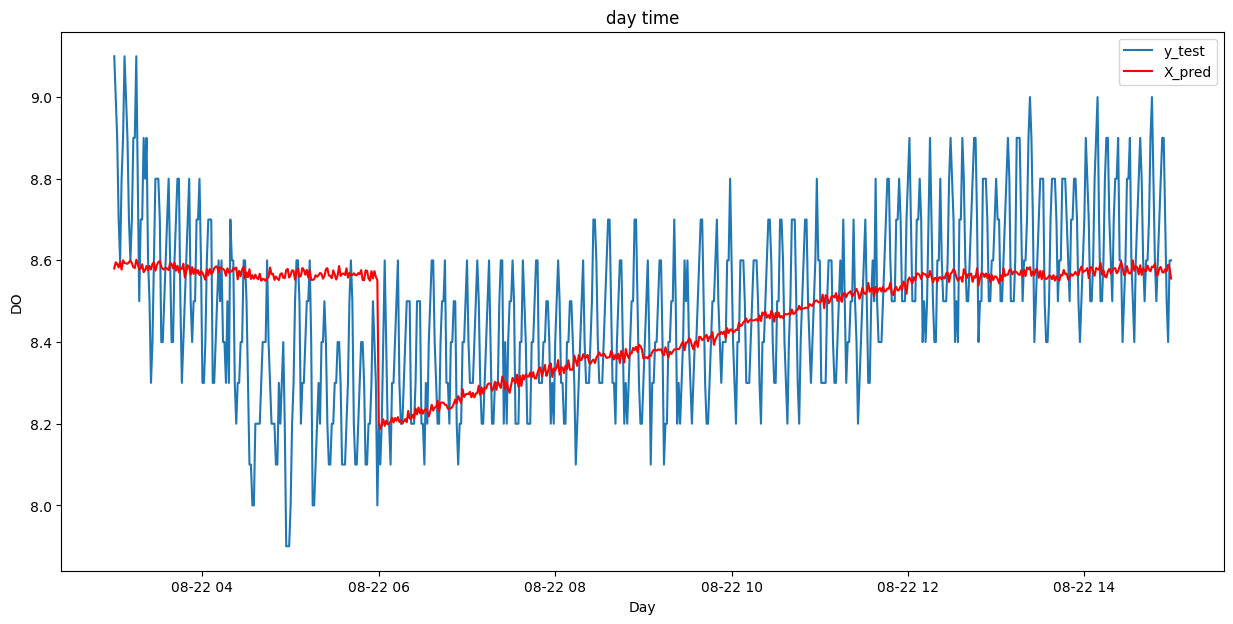

1/1 [==============================] - 0s 57ms/step - loss: 0.0419 - mae: 0.1633 - r_squared: 0.0911
MSE // MAE // R-squared  [0.04189549759030342, 0.16331793367862701, 0.09113973379135132]


In [ ]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test, oneday_y_test_reshape)